### 代码实现

In [1]:
# 导入必要的库，torchinfo用于查看模型结构
import torch
import torch.nn as nn
from torchinfo import summary

### 结构定义

In [2]:
# 定义LeNet的网络结构
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 卷积层1：输入1个通道，输出6个通道，卷积核大小为5x5，后接BN
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.BatchNorm2d(6)
        )
        # 卷积层2：输入6个通道，输出16个通道，卷积核大小为5x5，后接BN
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16)
        )
        # 全连接层1：输入16x4x4=256个节点，输出120个节点，由于输入数据略有差异，修改为16x4x4
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.BatchNorm1d(120)
        )
        # 全连接层2：输入120个节点，输出84个节点
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.BatchNorm1d(84)
        )
        # 输出层：输入84个节点，输出10个节点
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 使用ReLU激活函数，并进行最大池化
        x = torch.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        # 使用ReLU激活函数，并进行最大池化
        x = torch.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        # 将多维张量展平为一维张量
        x = x.view(-1, 16 * 4 * 4)
        # 全连接层
        x = torch.relu(self.fc1(x))
        # 全连接层
        x = torch.relu(self.fc2(x))
        # 全连接层
        x = self.fc3(x)
        return x

### 网络结构

In [3]:
# 查看模型结构及参数量，input_size表示示例输入数据的维度信息
summary(LeNet(), input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 6, 24, 24]            --
│    └─Conv2d: 2-1                       [1, 6, 24, 24]            156
│    └─BatchNorm2d: 2-2                  [1, 6, 24, 24]            12
├─Sequential: 1-2                        [1, 16, 8, 8]             --
│    └─Conv2d: 2-3                       [1, 16, 8, 8]             2,416
│    └─BatchNorm2d: 2-4                  [1, 16, 8, 8]             32
├─Sequential: 1-3                        [1, 120]                  --
│    └─Linear: 2-5                       [1, 120]                  30,840
│    └─BatchNorm1d: 2-6                  [1, 120]                  240
├─Sequential: 1-4                        [1, 84]                   --
│    └─Linear: 2-7                       [1, 84]                   10,164
│    └─BatchNorm1d: 2-8                  [1, 84]                   168
├

### 模型训练

Epoch: 0 Loss: 2.2088656986293165 Acc: 0.9578
Epoch: 2 Loss: 1.4376559603001913 Acc: 0.979  
Epoch: 4 Loss: 1.228520721191793 Acc: 0.9803  
Epoch: 6 Loss: 1.106042682456222 Acc: 0.9859  
Epoch: 8 Loss: 1.0158490855052476 Acc: 0.9883 
100%|██████████| 10/10 [01:56<00:00, 11.62s/it]


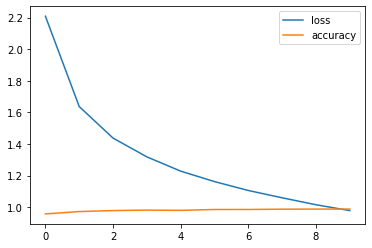

Accuracy: 0.9886


In [4]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import * # tqdm用于显示进度条并评估任务时间开销
import numpy as np
import sys

# 设置随机种子
torch.manual_seed(0)

# 定义模型、优化器、损失函数
model = LeNet()
optimizer = optim.SGD(model.parameters(), lr=0.02)
criterion = nn.CrossEntropyLoss()

# 设置数据变换和数据加载器
transform = transforms.Compose([
    transforms.ToTensor(),  # 将数据转换为张量
])

# 加载训练数据
train_dataset = datasets.MNIST(root='../data/mnist/', train=True, download=True, transform=transform)
# 实例化训练数据加载器
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
# 加载测试数据
test_dataset = datasets.MNIST(root='../data/mnist/', train=False, download=True, transform=transform)
# 实例化测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 设置epoch数并开始训练
num_epochs = 10  # 设置epoch数
loss_history = []  # 创建损失历史记录列表
acc_history = []   # 创建准确率历史记录列表

# tqdm用于显示进度条并评估任务时间开销
for epoch in tqdm(range(num_epochs), file=sys.stdout):
    # 记录损失和预测正确数
    total_loss = 0
    total_correct = 0
    
    # 批量训练
    model.train()
    for inputs, labels in train_loader:

        # 预测、损失函数、反向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 记录训练集loss
        total_loss += loss.item()
    
    # 测试模型，不计算梯度
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:

            # 预测
            outputs = model(inputs)
            # 记录测试集预测正确数
            total_correct += (outputs.argmax(1) == labels).sum().item()
        
    # 记录训练集损失和测试集准确率
    loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
    acc_history.append(total_correct / len(test_dataset))# 将准确率加入准确率历史记录列表
    
    # 打印中间值
    if epoch % 2 == 0:
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch, loss_history[-1], acc_history[-1]))

# 使用Matplotlib绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

# 输出准确率
print("Accuracy:", acc_history[-1])